In [1]:
CLUSTER_TYPE ='local'

In [2]:
# set env variable
%env CLUSTER_TYPE $CLUSTER_TYPE

env: CLUSTER_TYPE=local


In [3]:
if CLUSTER_TYPE=='local':
    import findspark
    findspark.init('/home/hilario/PoD/2ndSemester/MAPD-B/Data-processing/Labs/Spark_Migliorini/spark/spark-3.1.2-bin-hadoop3.2//')

In [4]:
%%script bash --no-raise-error

if [[ "$CLUSTER_TYPE" != "docker_cluster" ]]; then
    echo "Launching master and worker"
    
    # start master 
    $SPARK_HOME/sbin/start-master.sh --host localhost \
        --port 7077 --webui-port 8080
    
    # start worker
    $SPARK_HOME/sbin/start-worker.sh spark://localhost:7077 \
        --cores 2 --memory 2g
fi

Launching master and worker
org.apache.spark.deploy.master.Master running as process 7328.  Stop it first.
org.apache.spark.deploy.worker.Worker running as process 7413.  Stop it first.


In [5]:
from pyspark.sql import SparkSession

if CLUSTER_TYPE in ['local', 'docker_container']:
    
    spark = SparkSession.builder \
        .master("spark://localhost:7077")\
        .appName("First spark application")\
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
        .getOrCreate()

elif CLUSTER_TYPE == 'docker_cluster':
    
    # use the provided master
    spark = SparkSession.builder \
        .master("spark://spark-master:7077")\
        .appName("First spark application")\
        .config("spark.executor.memory", "512m")\
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
        .getOrCreate()
    
spark

In [6]:
sc = spark.sparkContext
sc

<SparkContext master=spark://localhost:7077 appName=First spark application>

# LALALALA

In [7]:
# load dataset on dataset/lecture2/dimuon
df = spark.read \
    .option("inferTimestamp","false") \
    .option("prefersDecimal","false") \
    .option("header",True)\
    .option("inferSchema" , "true")\
    .format('csv') \
    .load('Data/data_000000.csv')

In [8]:
df.show()

+----+----+-----------+----------+----------+----------+
|HEAD|FPGA|TDC_CHANNEL| ORBIT_CNT|BX_COUNTER|  TDC_MEAS|
+----+----+-----------+----------+----------+----------+
|   1|   1|          0|3387315431|         0|       130|
|   0|   1|          2|3387315431|      1119|        24|
|   4|   1|          0|3387315431|         0| -0.573730|
|   5|   1|          0|3387315431|         0| 45.500000|
|   2|   0|         75|3387200947|      2922|         2|
|   2|   0|        105|3387200955|      2227|        29|
|   2|   0|        107|3387200955|      2234|         7|
|   2|   0|        126|3387200973|       476|        29|
|   2|   1|         55|3387200955|      1797|        12|
|   2|   1|         36|3387200956|      2165|        28|
|   2|   1|         51|3387200970|       249|        14|
|   2|   1|         90|3387200973|       475|        28|
|   4|   0|          0|3387339329|         0| -0.537109|
|   5|   0|          0|3387339329|         0|-41.531250|
|   3|   0|          0|33873393

In [9]:
# dataset schema
df.printSchema()

root
 |-- HEAD: integer (nullable = true)
 |-- FPGA: integer (nullable = true)
 |-- TDC_CHANNEL: integer (nullable = true)
 |-- ORBIT_CNT: long (nullable = true)
 |-- BX_COUNTER: integer (nullable = true)
 |-- TDC_MEAS: string (nullable = true)



In [10]:
# show first rows
df.show(5)

+----+----+-----------+----------+----------+---------+
|HEAD|FPGA|TDC_CHANNEL| ORBIT_CNT|BX_COUNTER| TDC_MEAS|
+----+----+-----------+----------+----------+---------+
|   1|   1|          0|3387315431|         0|      130|
|   0|   1|          2|3387315431|      1119|       24|
|   4|   1|          0|3387315431|         0|-0.573730|
|   5|   1|          0|3387315431|         0|45.500000|
|   2|   0|         75|3387200947|      2922|        2|
+----+----+-----------+----------+----------+---------+
only showing top 5 rows



In [11]:
# select only events with two muons
clean_df = df.where(df['HEAD']==2)
clean_df.show(5)

+----+----+-----------+----------+----------+--------+
|HEAD|FPGA|TDC_CHANNEL| ORBIT_CNT|BX_COUNTER|TDC_MEAS|
+----+----+-----------+----------+----------+--------+
|   2|   0|         75|3387200947|      2922|       2|
|   2|   0|        105|3387200955|      2227|      29|
|   2|   0|        107|3387200955|      2234|       7|
|   2|   0|        126|3387200973|       476|      29|
|   2|   1|         55|3387200955|      1797|      12|
+----+----+-----------+----------+----------+--------+
only showing top 5 rows



In [12]:
dimuon_flat = dimuon_df

NameError: name 'dimuon_df' is not defined

In [13]:
clean_df.select('TDC_CHANNEL').count()

1239940

In [14]:
from pyspark.sql.functions import concat, col

chamber_1 = clean_df.filter((col("FPGA") == 0) & (col("TDC_CHANNEL")>=0) & (col("TDC_CHANNEL")<=63))
chamber_2 = clean_df.filter((col("FPGA") == 0) & (col("TDC_CHANNEL")>=64) & (col("TDC_CHANNEL")<=127))
chamber_3 = clean_df.filter((col("FPGA") == 1) & (col("TDC_CHANNEL")>=0) & (col("TDC_CHANNEL")<=63))
chamber_4 = clean_df.filter((col("FPGA") == 1) & (col("TDC_CHANNEL")>=64) & (col("TDC_CHANNEL")<=127))

In [15]:
import numpy as np

histogram_results = {}
    
bins, counts = (
    chamber_1.select('TDC_CHANNEL')
    .rdd.map(lambda x: x.TDC_CHANNEL)
    .histogram(list(np.arange(0,170,5)))
)
    
histogram_results['bins'] = bins
histogram_results['counts'] = counts

In [16]:
import numpy as np


# compute it for each sample
histogram_results = {}
i=0
for chamber in [chamber_1, chamber_2, chamber_3, chamber_4]:
    
    chamber_name = ['chamber_1', 'chamber_2', 'chamber_3', 'chamber_4']
    histogram_results[chamber_name[i]] = {}
    print(chamber)
    bins, counts = (
        chamber.select('TDC_CHANNEL')
        .rdd.map(lambda x: x.TDC_CHANNEL)
        .histogram(list(np.arange(0,170,5)))
    )
    print(chamber_name[i])
    histogram_results[chamber_name[i]]['bins'] = bins
    histogram_results[chamber_name[i]]['counts'] = counts
    i +=1

DataFrame[HEAD: int, FPGA: int, TDC_CHANNEL: int, ORBIT_CNT: bigint, BX_COUNTER: int, TDC_MEAS: string]
chamber_1
DataFrame[HEAD: int, FPGA: int, TDC_CHANNEL: int, ORBIT_CNT: bigint, BX_COUNTER: int, TDC_MEAS: string]
chamber_2
DataFrame[HEAD: int, FPGA: int, TDC_CHANNEL: int, ORBIT_CNT: bigint, BX_COUNTER: int, TDC_MEAS: string]
chamber_3
DataFrame[HEAD: int, FPGA: int, TDC_CHANNEL: int, ORBIT_CNT: bigint, BX_COUNTER: int, TDC_MEAS: string]
chamber_4


In [17]:
histogram_results

{'chamber_1': {'bins': [0,
   5,
   10,
   15,
   20,
   25,
   30,
   35,
   40,
   45,
   50,
   55,
   60,
   65,
   70,
   75,
   80,
   85,
   90,
   95,
   100,
   105,
   110,
   115,
   120,
   125,
   130,
   135,
   140,
   145,
   150,
   155,
   160,
   165],
  'counts': [18567,
   19141,
   10776,
   18020,
   17806,
   14964,
   14162,
   14538,
   18517,
   18792,
   11331,
   18499,
   14868,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]},
 'chamber_2': {'bins': [0,
   5,
   10,
   15,
   20,
   25,
   30,
   35,
   40,
   45,
   50,
   55,
   60,
   65,
   70,
   75,
   80,
   85,
   90,
   95,
   100,
   105,
   110,
   115,
   120,
   125,
   130,
   135,
   140,
   145,
   150,
   155,
   160,
   165],
  'counts': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   7690,
   41741,
   43451,
   31819,
   35412,
   28268,
   27082,
   27605,
   40213,
   25355,
   43439,
   

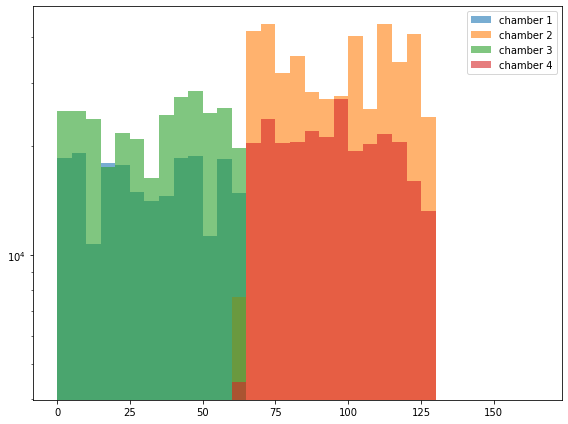

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

mc_res = histogram_results['chamber_1']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='chamber 1', alpha=0.6
)

mc_res = histogram_results['chamber_2']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='chamber 2', alpha=0.6
)

mc_res = histogram_results['chamber_3']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='chamber 3', alpha=0.6
)


mc_res = histogram_results['chamber_4']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='chamber 4', alpha=0.6
)


plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.semilogy()
plt.tight_layout()
plt.show()

In [19]:
histogram_results_2 = {}
i=0
for chamber in [chamber_1, chamber_2, chamber_3, chamber_4]:
    
    chamber_name = ['chamber_1', 'chamber_2', 'chamber_3', 'chamber_4']
    histogram_results_2[chamber_name[i]] = {}
    bins, counts = (
        chamber.groupBy('TDC_CHANNEL','ORBIT_CNT')
        .count()
        .select('ORBIT_CNT')
        .rdd.map(lambda x: x.ORBIT_CNT)
        .histogram(list(np.arange(6.e5,1.e7,0.5e6)))
    )
    histogram_results_2[chamber_name[i]]['bins'] = bins
    histogram_results_2[chamber_name[i]]['counts'] = counts
    i +=1

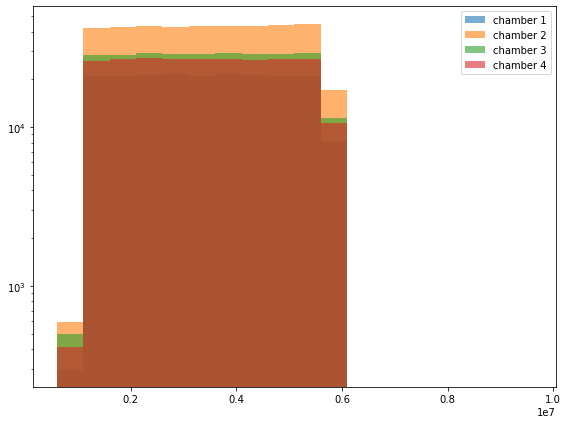

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

mc_res = histogram_results_2['chamber_1']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='chamber 1', alpha=0.6
)

mc_res = histogram_results_2['chamber_2']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='chamber 2', alpha=0.6
)

mc_res = histogram_results_2['chamber_3']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='chamber 3', alpha=0.6
)


mc_res = histogram_results_2['chamber_4']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='chamber 4', alpha=0.6
)


plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.semilogy()
plt.tight_layout()
plt.show()

In [1]:

a ={'Total Count': 5540, 'Chamber_1': {'Hist_1': {'Bins': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165], 'Counts': [59, 80, 53, 96, 65, 59, 54, 47, 79, 74, 49, 79, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}, 'Chamber_2': {'Hist_1': {'Bins': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165], 'Counts': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 204, 183, 140, 150, 117, 121, 158, 166, 127, 217, 175, 206, 98, 0, 0, 0, 0, 0, 0, 0]}}, 'Chamber_3': {'Hist_1': {'Bins': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165], 'Counts': [106, 117, 111, 62, 105, 95, 70, 169, 122, 104, 120, 106, 79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}, 'Chamber_4': {'Hist_1': {'Bins': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165], 'Counts': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 107, 84, 99, 112, 87, 82, 101, 89, 97, 112, 81, 84, 61, 0, 0, 0, 0, 0, 0, 0]}}}


In [8]:
x= a['Chamber_1']['Hist_1']['Bins']
y= a['Chamber_1']['Hist_1']['Counts']

(array([59., 80., 53., 96., 65., 59., 54., 47., 79., 74., 49., 79., 80.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
        130, 135, 140, 145, 150, 155, 160, 165]),
 <BarContainer object of 33 artists>)

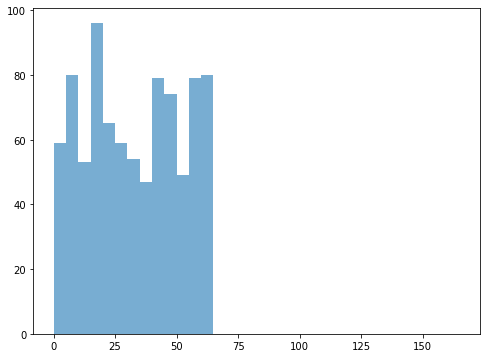

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))

mc_res = a['Chamber_1']['Hist_1']
bin_centers = mc_res['Bins'][:-1] + np.diff(mc_res['Bins'])/2
plt.hist(
    bin_centers, weights=mc_res['Counts'], bins=mc_res['Bins'],
    label='chamber 1', alpha=0.6
)